In [13]:
import os
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ["CUDA_VISIBLE_DEVICES"] = "0" 

import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
# import tensorflow as tf
from tensorflow.keras.models import load_model
from skimage import metrics

import matplotlib.transforms as transforms
from math import pi

In [2]:
path = os.path.abspath("..")

X_val = np.load(path+"/train_test_data/X_val.npy")
y_val = np.load (path+"/train_test_data/y_val.npy")

X_val.shape, y_val.shape

((137, 17, 64, 64, 3), (137, 17, 64, 64, 1))

In [3]:
model = load_model(path+"/lstm_model_2.h5")
history = np.load(path+"/history_2.npy", allow_pickle=True).item()

In [4]:
def scale_array(arr):
    arr_min = np.min(arr)  ## Flattens the array and finds the min value inside it
    arr_max = np.max(arr)  ## Flattens the array and finds the max value inside it
    scaled_array = (arr - arr_min) / (arr_max - arr_min) * 255
    scaled_array = scaled_array.astype(np.uint8)
    
    return scaled_array

In [5]:
GT_array = y_val
a, b, c, d, e = y_val.shape[0], y_val.shape[1], y_val.shape[2], y_val.shape[3], y_val.shape[4] 
PD_array = np.zeros((a, b, c, d, e))   ## Predicted arrays

for i in range(X_val.shape[0]):
    frames = X_val[i]   ## taking 1 validation video sample at one time
    PD_array[i] = model.predict(np.expand_dims(frames, axis=0), verbose=0, workers=10, use_multiprocessing=True)

GT_scaled = scale_array(y_val)
PD_scaled = scale_array(PD_array)

GT_array.shape, PD_array.shape

((137, 17, 64, 64, 1), (137, 17, 64, 64, 1))

In [6]:
X_g1 = np.delete(np.concatenate((X_val, PD_array), axis=-1), 0, axis=-1)
X_g1 = np.delete(X_g1, -1, axis=1)
y_g1 = np.delete(y_val, 0, axis=1)

a, b, c, d, e = y_g1.shape[0], y_g1.shape[1], y_g1.shape[2], y_g1.shape[3], y_g1.shape[4] 
PD_G1 = np.zeros((a, b, c, d, e))   ## Predicted arrays
for i in range(X_g1.shape[0]):
    frames = X_g1[i]   ## taking 1 validation video sample at one time
    PD_G1[i] = model.predict(np.expand_dims(frames, axis=0), verbose=0, workers=10, use_multiprocessing=True)

y_g1_scaled = scale_array(y_g1)
PD_G1_scaled = scale_array(PD_G1)

y_g1.shape, PD_G1.shape

((137, 16, 64, 64, 1), (137, 16, 64, 64, 1))

In [7]:
X_g2 = np.delete(np.concatenate((X_g1, PD_G1), axis=-1), 0, axis=-1)
X_g2 = np.delete(X_g2, -1, axis=1)
y_g2 = np.delete(y_g1, 0, axis=1)

a, b, c, d, e = y_g2.shape[0], y_g2.shape[1], y_g2.shape[2], y_g2.shape[3], y_g2.shape[4] 
PD_G2 = np.zeros((a, b, c, d, e))   ## Predicted arrays

for i in range(X_g1.shape[0]):
    frames = X_g2[i]   ## taking 1 validation video sample at one time
    PD_G2[i] = model.predict(np.expand_dims(frames, axis=0), verbose=0, workers=10, use_multiprocessing=True)

y_g2_scaled = scale_array(y_g2)
PD_G2_scaled = scale_array(PD_G2)

y_g2.shape, PD_G2.shape

((137, 15, 64, 64, 1), (137, 15, 64, 64, 1))

In [8]:
X_g3 = np.delete(np.concatenate((X_g2, PD_G2), axis=-1), 0, axis=-1)
X_g3 = np.delete(X_g3, -1, axis=1)
y_g3 = np.delete(y_g2, 0, axis=1)

a, b, c, d, e = y_g3.shape[0], y_g3.shape[1], y_g3.shape[2], y_g3.shape[3], y_g3.shape[4] 
PD_G3 = np.zeros((a, b, c, d, e))   ## Predicted arrays

for i in range(X_g2.shape[0]):
    frames = X_g3[i]   ## taking 1 validation video sample at one time
    PD_G3[i] = model.predict(np.expand_dims(frames, axis=0), verbose=0, workers=10, use_multiprocessing=True)

y_g3_scaled = scale_array(y_g3)
PD_G3_scaled = scale_array(PD_G3)

y_g3.shape, PD_G3.shape

((137, 14, 64, 64, 1), (137, 14, 64, 64, 1))

In [9]:
GT_scaled = scale_array(y_val)
PD_scaled = scale_array(PD_array)

a, b, c, d, e = y_val.shape[0], y_val.shape[1], y_val.shape[2], y_val.shape[3], y_val.shape[4] 

## For Individual Image Frames
mse_g0 = np.zeros((a,b))
rmse_g0 = np.zeros((a,b))
psnr_g0 = np.zeros((a,b))
ssim_g0 = np.zeros((a,b))

for i in range(GT_scaled.shape[0]):
  for j in range(GT_scaled.shape[1]):
    mse_g0[i][j] = metrics.mean_squared_error(GT_scaled[i,j,:,:,0], PD_scaled[i,j,:,:,0])
    rmse_g0[i][j] = metrics.normalized_root_mse(GT_scaled[i,j,:,:,0], PD_scaled[i,j,:,:,0])
    psnr_g0[i][j] = metrics.peak_signal_noise_ratio(GT_scaled[i,j,:,:,0], PD_scaled[i,j,:,:,0], data_range=None)
    ssim_g0[i][j] = metrics.structural_similarity(GT_scaled[i,j,:,:,0], PD_scaled[i,j,:,:,0], win_size=3)


## For Individual Video Sequence (17 frames)
mse_g0_vs = np.zeros((a))
rmse_g0_vs = np.zeros((a))
psnr_g0_vs = np.zeros((a))
ssim_g0_vs = np.zeros((a))

for i in range(GT_scaled.shape[0]):
  # for j in range(GT_scaled.shape[1]):
  mse_g0_vs[i] = metrics.mean_squared_error(GT_scaled[i,:,:,:,0], PD_scaled[i,:,:,:,0])
  rmse_g0_vs[i] = metrics.normalized_root_mse(GT_scaled[i,:,:,:,0], PD_scaled[i,:,:,:,0])
  psnr_g0_vs[i] = metrics.peak_signal_noise_ratio(GT_scaled[i,:,:,:,0], PD_scaled[i,:,:,:,0], data_range=None)
  ssim_g0_vs[i] = metrics.structural_similarity(GT_scaled[i,:,:,:,0], PD_scaled[i,:,:,:,0], win_size=3)


mse_g0_all = metrics.mean_squared_error(GT_scaled, PD_scaled)
rmse_g0_all = metrics.normalized_root_mse(GT_scaled, PD_scaled)
psnr_g0_all = metrics.peak_signal_noise_ratio(GT_scaled, PD_scaled, data_range=None)
ssim_g0_all = metrics.structural_similarity(GT_scaled[:,:,:,:,0], PD_scaled[:,:,:,:,0], win_size=3)


In [10]:
y_g1_scaled = scale_array(y_g1)
PD_G1_scaled = scale_array(PD_G1)

a, b, c, d, e = y_g1.shape[0], y_g1.shape[1], y_g1.shape[2], y_g1.shape[3], y_g1.shape[4] 

## For Individual Image Frames
mse_g1 = np.zeros((a,b))
rmse_g1 = np.zeros((a,b))
psnr_g1 = np.zeros((a,b))
ssim_g1 = np.zeros((a,b))

for i in range(y_g1_scaled.shape[0]):
  for j in range(y_g1_scaled.shape[1]):
    mse_g1[i][j] = metrics.mean_squared_error(y_g1_scaled[i,j,:,:,0], PD_G1_scaled[i,j,:,:,0])
    rmse_g1[i][j] = metrics.normalized_root_mse(y_g1_scaled[i,j,:,:,0], PD_G1_scaled[i,j,:,:,0])
    psnr_g1[i][j] = metrics.peak_signal_noise_ratio(y_g1_scaled[i,j,:,:,0], PD_G1_scaled[i,j,:,:,0], data_range=None)
    ssim_g1[i][j] = metrics.structural_similarity(y_g1_scaled[i,j,:,:,0], PD_G1_scaled[i,j,:,:,0], win_size=3)

## For Individual Video Sequence (17 frames)
mse_g1_vs = np.zeros((a))
rmse_g1_vs = np.zeros((a))
psnr_g1_vs = np.zeros((a))
ssim_g1_vs = np.zeros((a))

for i in range(y_g1_scaled.shape[0]):
  # for j in range(y_g1_scaled.shape[1]):
  mse_g1_vs[i] = metrics.mean_squared_error(y_g1_scaled[i,:,:,:,0], PD_G1_scaled[i,:,:,:,0])
  rmse_g1_vs[i] = metrics.normalized_root_mse(y_g1_scaled[i,:,:,:,0], PD_G1_scaled[i,:,:,:,0])
  psnr_g1_vs[i] = metrics.peak_signal_noise_ratio(y_g1_scaled[i,:,:,:,0], PD_G1_scaled[i,:,:,:,0], data_range=None)
  ssim_g1_vs[i] = metrics.structural_similarity(y_g1_scaled[i,:,:,:,0], PD_G1_scaled[i,:,:,:,0], win_size=3)


## For ALL Validation set at once
mse_g1_all = metrics.mean_squared_error(y_g1_scaled, PD_G1_scaled)
rmse_g1_all = metrics.normalized_root_mse(y_g1_scaled, PD_G1_scaled)
psnr_g1_all = metrics.peak_signal_noise_ratio(y_g1_scaled, PD_G1_scaled, data_range=None)
ssim_g1_all = metrics.structural_similarity(y_g1_scaled[:,:,:,:,0], PD_G1_scaled[:,:,:,:,0], win_size=3)


In [11]:
y_g2_scaled = scale_array(y_g2)
PD_G2_scaled = scale_array(PD_G2)

a, b, c, d, e = y_g2.shape[0], y_g2.shape[1], y_g2.shape[2], y_g2.shape[3], y_g2.shape[4] 

## For Individual Image Frames
mse_g2 = np.zeros((a,b))
rmse_g2 = np.zeros((a,b))
psnr_g2 = np.zeros((a,b))
ssim_g2 = np.zeros((a,b))

for i in range(y_g2_scaled.shape[0]):
  for j in range(y_g2_scaled.shape[1]):
    mse_g2[i][j] = metrics.mean_squared_error(y_g2_scaled[i,j,:,:,0], PD_G2_scaled[i,j,:,:,0])
    rmse_g2[i][j] = metrics.normalized_root_mse(y_g2_scaled[i,j,:,:,0], PD_G2_scaled[i,j,:,:,0])
    psnr_g2[i][j] = metrics.peak_signal_noise_ratio(y_g2_scaled[i,j,:,:,0], PD_G2_scaled[i,j,:,:,0], data_range=None)
    ssim_g2[i][j] = metrics.structural_similarity(y_g2_scaled[i,j,:,:,0], PD_G2_scaled[i,j,:,:,0], win_size=3)


## For Individual Video Sequence (17 frames)
mse_g2_vs = np.zeros((a))
rmse_g2_vs = np.zeros((a))
psnr_g2_vs = np.zeros((a))
ssim_g2_vs = np.zeros((a))

for i in range(y_g2_scaled.shape[0]):
  # for j in range(y_g2_scaled.shape[1]):
  mse_g2_vs[i] = metrics.mean_squared_error(y_g2_scaled[i,:,:,:,0], PD_G2_scaled[i,:,:,:,0])
  rmse_g2_vs[i] = metrics.normalized_root_mse(y_g2_scaled[i,:,:,:,0], PD_G2_scaled[i,:,:,:,0])
  psnr_g2_vs[i] = metrics.peak_signal_noise_ratio(y_g2_scaled[i,:,:,:,0], PD_G2_scaled[i,:,:,:,0], data_range=None)
  ssim_g2_vs[i] = metrics.structural_similarity(y_g2_scaled[i,:,:,:,0], PD_G2_scaled[i,:,:,:,0], win_size=3)

## For ALL Validation set at once
mse_g2_all = metrics.mean_squared_error(y_g2_scaled, PD_G2_scaled)
rmse_g2_all = metrics.normalized_root_mse(y_g2_scaled, PD_G2_scaled)
psnr_g2_all = metrics.peak_signal_noise_ratio(y_g2_scaled, PD_G2_scaled, data_range=None)
ssim_g2_all = metrics.structural_similarity(y_g2_scaled[:,:,:,:,0], PD_G2_scaled[:,:,:,:,0], win_size=3)


In [12]:
y_g3_scaled = scale_array(y_g3)
PD_G3_scaled = scale_array(PD_G3)

a, b, c, d, e = y_g3.shape[0], y_g3.shape[1], y_g3.shape[2], y_g3.shape[3], y_g3.shape[4] 

## For Individual Image Frames
mse_g3 = np.zeros((a,b))
rmse_g3 = np.zeros((a,b))
psnr_g3 = np.zeros((a,b))
ssim_g3 = np.zeros((a,b))

for i in range(y_g3_scaled.shape[0]):
  for j in range(y_g3_scaled.shape[1]):
    mse_g3[i][j] = metrics.mean_squared_error(y_g3_scaled[i,j,:,:,0], PD_G3_scaled[i,j,:,:,0])
    rmse_g3[i][j] = metrics.normalized_root_mse(y_g3_scaled[i,j,:,:,0], PD_G3_scaled[i,j,:,:,0])
    psnr_g3[i][j] = metrics.peak_signal_noise_ratio(y_g3_scaled[i,j,:,:,0], PD_G3_scaled[i,j,:,:,0], data_range=None)
    ssim_g3[i][j] = metrics.structural_similarity(y_g3_scaled[i,j,:,:,0], PD_G3_scaled[i,j,:,:,0], win_size=3)

## For Individual Video Sequence (17 frames)
mse_g3_vs = np.zeros((a))
rmse_g3_vs = np.zeros((a))
psnr_g3_vs = np.zeros((a))
ssim_g3_vs = np.zeros((a))

for i in range(y_g3_scaled.shape[0]):
  # for j in range(y_g3_scaled.shape[1]):
  mse_g3_vs[i] = metrics.mean_squared_error(y_g3_scaled[i,:,:,:,0], PD_G3_scaled[i,:,:,:,0])
  rmse_g3_vs[i] = metrics.normalized_root_mse(y_g3_scaled[i,:,:,:,0], PD_G3_scaled[i,:,:,:,0])
  psnr_g3_vs[i] = metrics.peak_signal_noise_ratio(y_g3_scaled[i,:,:,:,0], PD_G3_scaled[i,:,:,:,0], data_range=None)
  ssim_g3_vs[i] = metrics.structural_similarity(y_g3_scaled[i,:,:,:,0], PD_G3_scaled[i,:,:,:,0], win_size=3)

## For ALL Validation set at once
mse_g3_all = metrics.mean_squared_error(y_g3_scaled, PD_G3_scaled)
rmse_g3_all = metrics.normalized_root_mse(y_g3_scaled, PD_G3_scaled)
psnr_g3_all = metrics.peak_signal_noise_ratio(y_g3_scaled, PD_G3_scaled, data_range=None)
ssim_g3_all = metrics.structural_similarity(y_g3_scaled[:,:,:,:,0], PD_G3_scaled[:,:,:,:,0], win_size=3)


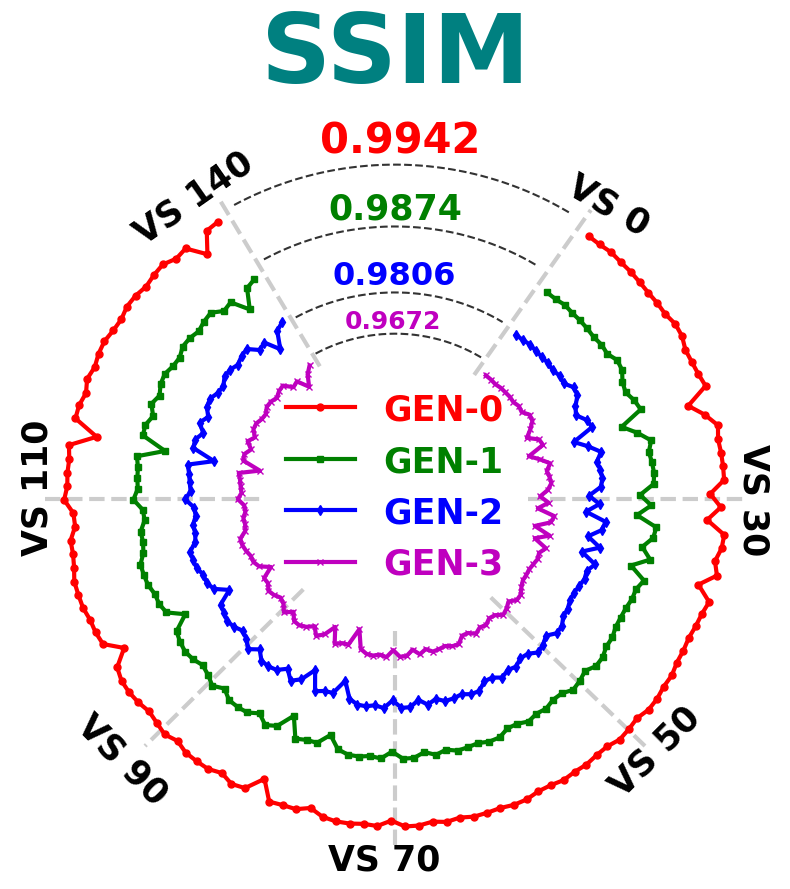

In [79]:
def wrap_around(radii, s,):
    thetas = [i * (330 / len(radii)) for i in range(15, len(radii))]
    xs = [(s * radius * np.sin(np.deg2rad(theta))) for radius, theta in zip(radii, thetas)]
    ys = [(s * radius * np.cos(np.deg2rad(theta))) for radius, theta in zip(radii, thetas)]
    return xs,ys

def labels(radii, s,):
    thetas = [i * (60 / len(radii)) for i in range(-65, len(radii))]
    xs = [(s * radius * np.sin(np.deg2rad(theta))) for radius, theta in zip(radii, thetas)]
    ys = [(s * radius * np.cos(np.deg2rad(theta))) for radius, theta in zip(radii, thetas)]
    return  xs,ys


x0,y0 = wrap_around(ssim_g0_vs, s=20)
x1,y1 = wrap_around(ssim_g1_vs, s=16)
x2,y2 = wrap_around(ssim_g2_vs, s=13)
x3,y3 = wrap_around(ssim_g3_vs, s=10)

a =  np.ones(len(ssim_g0_vs))
l0 = labels(a , 20.25)
l1 = labels(a , 16.5)
l2 = labels(a , 12.5)
l3 = labels(a , 10)
l4 = labels(a , 5)

plt.rcParams["figure.figsize"] = (8,9)

plt.plot([4.75, 11.75], [7.5, 17.5], '--', color = 'black', linewidth=3,  alpha=0.2)
plt.text(10, 16, s="VS 0", color='k',fontsize=25, weight = 'bold', rotation=-30)
plt.hlines(y=0, xmin=8, xmax=21,  color = 'black', linewidth=3, linestyles='dashed', alpha=0.2)
plt.text(20.5, -3, s="VS 30", color='k',fontsize=25, weight = 'bold', rotation=270)
plt.plot([15, 5.5], [-15, -5.75], '--', color = 'black', linewidth=3,  alpha=0.2)
plt.text(12.5, -18, s="VS 50", color='k',fontsize=25, weight = 'bold', rotation=45)
plt.vlines(x=0, ymin=-21, ymax=-8,  color = 'black', linewidth=3, linestyles='dashed', alpha=0.2)
plt.text(-4, -22.5, s="VS 70", color='k',fontsize=25, weight = 'bold', rotation=0)
plt.plot([-5.5, -15], [-5.5, -15], '--', color = 'black', linewidth=3,  alpha=0.2)
plt.text(-19.5, -18.5, s="VS 90", color='k',fontsize=25, weight = 'bold', rotation=-45)
plt.hlines(y=0, xmin=-21, xmax=-8,  color = 'black', linewidth=3, linestyles='dashed', alpha=0.2)
plt.text(-22.5, -3, s="VS 110", color='k',fontsize=25, weight = 'bold', rotation=90)
plt.plot([-10.45, -4.5], [18, 8], '--', color = 'black', linewidth=3,  alpha=0.2)
plt.text(-16, 15.5, s="VS 140", color='k',fontsize=25, weight = 'bold', rotation=35)


plt.plot(x0, y0, '-o', color='red', label=r'GEN-0', linewidth=3, markersize=5)
plt.plot(x1, y1, '-s', color='green', label=r'GEN-1', linewidth=3, markersize=5)
plt.plot(x2, y2, '-d', color='blue', label=r'GEN-2', linewidth=3, markersize=5)
plt.plot(x3, y3, '-x', color='m', label=r'GEN-3', linewidth=3, markersize=5)

l0 = plt.plot(l0[0], l0[1], '--', color = 'black', alpha=0.8)
l1 = plt.plot(l1[0], l1[1], '--', color = 'black', alpha=0.8)
l2 = plt.plot(l2[0], l2[1], '--', color = 'black', alpha=0.8)
l3 = plt.plot(l3[0], l3[1], '--', color = 'black', alpha=0.8)
l4 = plt.plot(l4[0], l4[1], '--', color = 'white', alpha=0)


plt.text(-4.5, 21, s="0.9942", color='red',fontsize=30, weight = 'bold')
plt.text(-4.0, 17, s="0.9874", color='green',fontsize=25, weight = 'bold')
plt.text(-3.75, 13, s="0.9806", color='blue',fontsize=23, weight = 'bold')
plt.text(-3, 10.35, s="0.9672", color='m',fontsize=18, weight = 'bold')

plt.legend(loc=(0.34,0.38), prop={'weight':'bold', 'size':'25'}, frameon=False, labelcolor='linecolor').get_frame().set_facecolor('none')

plt.title("SSIM", color='teal',fontsize=70, weight = 'bold', rotation=0, pad=35)

plt.axis(False)
plt.tight_layout()
plt.savefig('figures/SSIM_GEN_Circ.png', transparent=True)

plt.savefig("/home/upadesh/1 Research Project/PhD/0 My Research Papers/0 ConvLSTM/manuscript/figures/SSIM_GEN_Circ.png", transparent=True)  ## For Manuscript
# plt.grid()
plt.show()

In [46]:
ssim_g0_all, ssim_g1_all, ssim_g2_all, ssim_g3_all

(0.9942957921101606,
 0.9874310391573395,
 0.9806071166841575,
 0.9675961438969446)

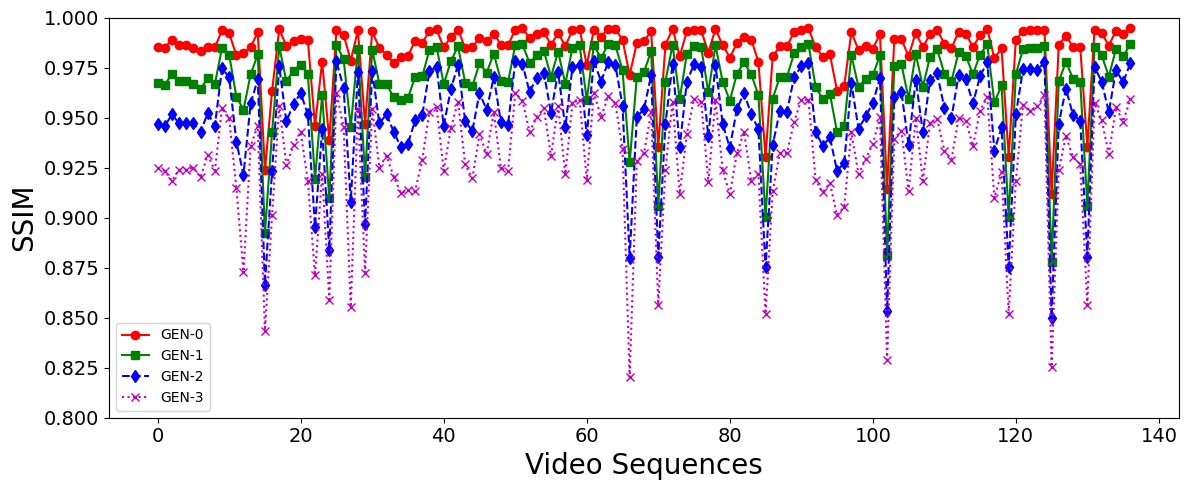

In [44]:
frame_no = np.arange(ssim_g0_vs.shape[0])

plt.rcParams["figure.figsize"] = (12,5)

plt.plot(frame_no, ssim_g0_vs, '-o', color='red', label='GEN-0')
plt.plot(frame_no, ssim_g1_vs, '-s', color='green', label='GEN-1')
plt.plot(frame_no, ssim_g2_vs,'--d', color='blue', label='GEN-2')
plt.plot(frame_no, ssim_g3_vs, ':x', color='m', label='GEN-3')


# plt.title("SSIM: 'Gen 0' Vs 'Gen 1' Vs 'Gen 2' Vs 'Gen 3'", size=20)
plt.xlabel("Video Sequences", size=20)
plt.ylabel("SSIM", size=20)
plt.xticks(fontsize=14, rotation=0)
plt.yticks(fontsize=14, rotation=0)
plt.legend()
plt.ylim([0.8,1.0])
plt.tight_layout()

# plt.savefig("figures/SSIM_Gen_0_to_3.png")
plt.show()